In [1]:
# !pip install scikit-surprise
# import pandas as pd
import nltk
# import gensim
# from gensim import corpora, models
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# import scipy.sparse
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np
# from gensim.models import CoherenceModel
# import matplotlib.pyplot as plt
# from sklearn.metrics import silhouette_score
# from tqdm import tqdm
# from gensim.models import CoherenceModel
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from surprise.model_selection import train_test_split
# import string
# import re
# from nltk.stem import PorterStemmer
# from surprise import Dataset, Reader, SVD
# from surprise import accuracy
# from sklearn.metrics.pairwise import linear_kernel
# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
!pip install gensim
!pip install tabulate

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Step 1 : Data Preprocessing




In [2]:
# Import necessary libraries
import pandas as pd
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Load the CSV files containing movie details and critics details
movie_data = pd.read_csv('/content/rotten_tomatoes_movies.csv')

# Remove missing values (NaN)
movie_data.dropna(subset=['movie_title', 'critics_consensus', 'tomatometer_rating', 'genre', 'audience_rating'], inplace=True)

# Remove duplicates
movie_data.drop_duplicates(subset=['movie_title', 'critics_consensus'], keep='first', inplace=True)

# Define a function for text preprocessing
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words, punctuation, and special characters
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]

    # Stemming (you can choose either stemming or lemmatization)
    #stemmer = PorterStemmer()
    #stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    #Lemmatization (alternative to stemming)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Convert text to lowercase
    preprocessed_text = ' '.join(lemmatized_tokens)  # You can use stemmed_tokens or lemmatized_tokens here

    return preprocessed_text

# Apply preprocessing to the 'critics_consensus' column
movie_data['critics_consensus'] = movie_data['critics_consensus'].apply(preprocess_text)
movie_data['movie_title'] = movie_data['movie_title'].apply(preprocess_text)

# Save the preprocessed data to a new CSV file
movie_data.to_csv('preprocessed_movie_data.csv', index=False)

# Step 2 : LDA Topic Modeling



In [3]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pandas as pd

# Load your preprocessed movie dataset (assuming it's in a DataFrame)
# Replace 'preprocessed_movie_data.csv' with the actual file path.
movie_data = pd.read_csv('preprocessed_movie_data.csv')

# Handle missing values by filling them with an empty string
movie_data['critics_consensus'].fillna('', inplace=True)

# Convert the preprocessed text to a list of tokens
documents = movie_data['critics_consensus'].apply(lambda x: x.split())

# Create a Gensim dictionary (a mapping from word IDs to words)
dictionary = corpora.Dictionary(documents)

# Create a document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Step 3: LDA Topic Modeling

# Define the number of topics you want to extract
num_topics = 5  # You can adjust this based on your specific needs

# Build the LDA model
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Print the topics and their top words
for topic in lda_model.print_topics(num_words=10):
    print(topic)

# Save the LDA model for future use
lda_model.save('lda_model')

# Save the Gensim dictionary
dictionary.save('dictionary')

(0, '0.017*"performance" + 0.012*"cast" + 0.008*"story" + 0.007*"comedy" + 0.007*"make" + 0.006*"enough" + 0.006*"lead" + 0.006*"work" + 0.006*"drama" + 0.005*"talented"')
(1, '0.008*"thriller" + 0.008*"performance" + 0.007*"story" + 0.006*"action" + 0.005*"enough" + 0.005*"character" + 0.005*"one" + 0.004*"make" + 0.004*"White" + 0.004*"comedy"')
(2, '0.007*"movie" + 0.006*"story" + 0.005*"horror" + 0.005*"genre" + 0.005*"good" + 0.005*"film" + 0.005*"cast" + 0.004*"character" + 0.004*"thriller" + 0.004*"offer"')
(3, '0.017*"performance" + 0.007*"movie" + 0.006*"character" + 0.005*"comedy" + 0.005*"strong" + 0.005*"film" + 0.005*"director" + 0.005*"Though" + 0.004*"funny" + 0.004*"offer"')
(4, '0.012*"may" + 0.008*"viewer" + 0.007*"fan" + 0.007*"movie" + 0.006*"story" + 0.006*"find" + 0.006*"character" + 0.006*"enough" + 0.006*"action" + 0.005*"offer"')


# Step 3: Topic Assignment

In [4]:
import pandas as pd
from gensim.models import LdaModel
from gensim import corpora

# Load your preprocessed movie dataset (assuming it's in a DataFrame)
# Replace 'preprocessed_movie_data.csv' with the actual file path.
movie_data = pd.read_csv('preprocessed_movie_data.csv')

# Load the LDA model
lda_model = LdaModel.load('lda_model')

# Load the Gensim dictionary
dictionary = corpora.Dictionary.load('dictionary')

# Define a function to get the most relevant topics for a review
def get_most_relevant_topics(review_text):
    if isinstance(review_text, str):  # Check if the review_text is not a missing value (a float in this case)
        # Tokenize and convert the review text to a Gensim document
        review_bow = dictionary.doc2bow(review_text.split())

        # Get the topic distribution for the review
        topic_distribution = lda_model.get_document_topics(review_bow)

        # Sort topics by their relevance to the review
        sorted_topics = sorted(topic_distribution, key=lambda x: x[1], reverse=True)

        # Return the most relevant topic(s) for the review
        return sorted_topics
    else:
        return []  # Return an empty list for missing values

# Apply the function to each review in your dataset and store the results in a new column
movie_data['relevant_topics'] = movie_data['critics_consensus'].apply(get_most_relevant_topics)

# You can also choose to extract the top N relevant topics from the list of topics if needed

# Save the updated dataset with relevant topics
movie_data.to_csv('movie_data_with_topics.csv', index=False)

# Step 4: Data Splitting

In [5]:
# Import necessary libraries
from sklearn.model_selection import train_test_split

# Load the dataset with topic assignments
movie_data = pd.read_csv('movie_data_with_topics.csv')

# Define the features (X) and target variables (y)
X = movie_data[['movie_title', 'genre', 'relevant_topics', 'tomatometer_rating']]
y = movie_data[['movie_title', 'audience_rating']]

# Split the dataset into training and test sets (e.g., 80% training and 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the training and test datasets
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Step 5: Model Building
This code uses TF-IDF vectorization to convert topic assignments into numerical features and then calculates the cosine similarity between movies based on these features. You can use this similarity matrix to provide recommendations.

Remember that this is a basic content-based recommendation model. You can further enhance it by incorporating other features like "tomatometer_rating," or explore other recommendation algorithms like collaborative filtering for a more advanced recommendation system.

In [ ]:
# Assuming you have already trained your LDA model

# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import ast

# Load the training dataset with topics and ratings
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
# Load the preprocessed dataset with topics
movie_data = pd.read_csv('movie_data_with_topics.csv')

# Create a TF-IDF vectorizer for text data (topics)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train['relevant_topics'].astype(str))

# Calculate the cosine similarity between movies based on topics
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations for a specific LDA topic
def get_topic_recommendations(lda_topic, cosine_sim=cosine_sim, top=10):
    # Safely evaluate the "relevant_topics" column as a list of tuples
    movie_data['relevant_topics'] = movie_data['relevant_topics'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

    # Reset the index of the dataframe manually to match the number of rows in your dataset
    movie_data.index = range(len(movie_data))

    # Create a list to store recommended movies
    recommended_movies = []

    for index, row in movie_data.iterrows():
        if row['relevant_topics']:
            # Extract the most relevant LDA topic for the movie
            max_topic = max(row['relevant_topics'], key=lambda item: item[1])[0]

            # Check if the index is within bounds
            if index < len(cosine_sim):
                # Check if the extracted topic matches the specified LDA topic
                if max_topic == lda_topic:
                    # Find similar movies based on cosine similarity
                    sim_scores = list(enumerate(cosine_sim[index]))
                    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
                    sim_scores = sim_scores[1:top+1]  # Exclude the movie itself
                    movie_indices = [i[0] for i in sim_scores]
                    recommended_movies.extend(list(movie_data['movie_title'].iloc[movie_indices]))

    # Remove duplicates from the recommended movies list
    print("\033[1mRecommended movies\033[0m")
    recommended_movies = list(set(recommended_movies))

    return recommended_movies

# Define a dictionary to store topic labels
topic_labels = {
    0: "action & thriller, horror, comedy, fun, classic, entertaining, good",
    1: "action & thriller, comedy, drama, strong powerful",
    2: "thriller, horror, documentary, comedy, funny, laugh, entertaining",
    3: "comedy, drama, charming ,strong, impressive, feel",
    4: "animated, classic, documentary, drama, beautiful. modern love, cinematic",
    # Add labels for other topics as needed
}

# Print and save the topic labels
for topic_number, label in topic_labels.items():
    print(f"Topic {topic_number}: {label}")

# Later, you can access the labels using the dictionary
topic_number_to_lookup = 0  # Change this to the desired topic number
if topic_number_to_lookup in topic_labels:
    print()
    label = topic_labels[topic_number_to_lookup]
    print(f"Label for Topic {topic_number_to_lookup}: {label}")
else:
    print(f"No label found for Topic {topic_number_to_lookup}")

topic_number_to_lookup = 1  # Change this to the desired topic number
if topic_number_to_lookup in topic_labels:
    label = topic_labels[topic_number_to_lookup]
    print(f"Label for Topic {topic_number_to_lookup}: {label}")
else:
    print(f"No label found for Topic {topic_number_to_lookup}")

topic_number_to_lookup = 2  # Change this to the desired topic number
if topic_number_to_lookup in topic_labels:
    label = topic_labels[topic_number_to_lookup]
    print(f"Label for Topic {topic_number_to_lookup}: {label}")
else:
    print(f"No label found for Topic {topic_number_to_lookup}")

topic_number_to_lookup = 3  # Change this to the desired topic number
if topic_number_to_lookup in topic_labels:
    label = topic_labels[topic_number_to_lookup]
    print(f"Label for Topic {topic_number_to_lookup}: {label}")
else:
    print(f"No label found for Topic {topic_number_to_lookup}")

topic_number_to_lookup = 4  # Change this to the desired topic number
if topic_number_to_lookup in topic_labels:
    label = topic_labels[topic_number_to_lookup]
    print(f"Label for Topic {topic_number_to_lookup}: {label}\n")
else:
    print(f"No label found for Topic {topic_number_to_lookup}")

    # Example: Get recommendations for LDA topic 2
topic_0_recommendations = get_topic_recommendations(0)
for movie in topic_0_recommendations:
    print(movie)

# Save the recommendation model (cosine_sim)
import joblib
joblib.dump(cosine_sim, 'cosine_similarity_model.pkl')

Topic 0: action & thriller, horror, comedy, fun, classic, entertaining, good
Topic 1: action & thriller, comedy, drama, strong powerful
Topic 2: thriller, horror, documentary, comedy, funny, laugh, entertaining
Topic 3: comedy, drama, charming ,strong, impressive, feel
Topic 4: animated, classic, documentary, drama, beautiful. modern love, cinematic

Label for Topic 0: action & thriller, horror, comedy, fun, classic, entertaining, good
Label for Topic 1: action & thriller, comedy, drama, strong powerful
Label for Topic 2: thriller, horror, documentary, comedy, funny, laugh, entertaining
Label for Topic 3: comedy, drama, charming ,strong, impressive, feel
Label for Topic 4: animated, classic, documentary, drama, beautiful. modern love, cinematic

Recommended movies
Percy Jackson Olympians Lightning Thief
Nas Time Illmatic
Lost City
Steps
Morning Light
Bridge San Luis Rey
Damned United
Adam Rib
Leagues Sea
Please Give
Shock Awe
Angry Men Twelve Angry Men
Criminal
Constantine Sword
Alexan

['cosine_similarity_model.pkl']

In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Load the training dataset with topics and ratings
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

# Create a TF-IDF vectorizer for text data (topics)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train['relevant_topics'].astype(str))

# Calculate the cosine similarity between movies based on topics
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

def get_recommendations(movie_title, cosine_sim=cosine_sim, top=10):
    try:
        idx = X_train[X_train['movie_title'] == movie_title].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top+1]  # Exclude the movie itself
        movie_indices = [i[0] for i in sim_scores]
        return X_train['movie_title'].iloc[movie_indices]
    except:
        return f"No recommendations found for {movie_title}"

# Example: Get recommendations for a movie
recommendations = get_recommendations("Please Give")
print(recommendations)

# Save the recommendation model (cosine_sim)
import joblib
joblib.dump(cosine_sim, 'cosine_similarity_model.pkl')


0                                     Fall
1                                    Awake
2                                   Bodied
3                         Rules Attraction
4                               Child Play
5    Hannah Cyrus Best Worlds Concert Tour
6                            Clockstoppers
7                               Dark River
8                Nutty Professor II Klumps
9                                 Identity
Name: movie_title, dtype: object


['cosine_similarity_model.pkl']

In [6]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import ast
from tabulate import tabulate

# Load the training dataset with topics and ratings
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
# Load the preprocessed dataset with topics
movie_data = pd.read_csv('movie_data_with_topics.csv')

# Create a TF-IDF vectorizer for text data (topics)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train['relevant_topics'].astype(str))

# Calculate the cosine similarity between movies based on topics
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to convert ratings to a 0-5 scale
def convert_to_0_5_scale(audience_rating):
    # Assuming your original ratings are on a scale of 0-100
    return audience_rating / 20.0

# Convert ratings to a 0-5 scale
movie_data['audience_rating'] = movie_data['audience_rating'].apply(convert_to_0_5_scale)

# Define a dictionary to store topic labels
topic_labels = {
    0: "action & thriller, horror, comedy, fun, classic, entertaining, good",
    1: "action & thriller, comedy, drama, strong powerful",
    2: "thriller, horror, documentary, comedy, funny, laugh, entertaining",
    3: "comedy, drama, charming ,strong, impressive, feel",
    4: "animated, classic, documentary, drama, beautiful. modern love, cinematic",
    # Add labels for other topics as needed
}

# Print and save the topic labels
print("\033[1mTopic Labels:\033[0m")
for topic_number, label in topic_labels.items():
    print(f"Topic {topic_number}: {label}")

# Function to get movie recommendations for a specific LDA topic
def get_topic_recommendations(lda_topic, cosine_sim=cosine_sim, top=10):
    # Safely evaluate the "relevant_topics" column as a list of tuples
    movie_data['relevant_topics'] = movie_data['relevant_topics'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

    # Reset the index of the dataframe manually to match the number of rows in your dataset
    movie_data.index = range(len(movie_data))

    # Create a list to store recommended movies
    recommended_movies = []

    for index, row in movie_data.iterrows():
        if row['relevant_topics']:
            # Extract the most relevant LDA topic for the movie
            max_topic = max(row['relevant_topics'], key=lambda item: item[1])[0]

            # Check if the index is within bounds
            if index < len(cosine_sim):
                # Check if the extracted topic matches the specified LDA topic
                if max_topic == lda_topic:
                    # Find similar movies based on cosine similarity
                    sim_scores = list(enumerate(cosine_sim[index]))
                    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
                    sim_scores = sim_scores[1:top+1]  # Exclude the movie itself
                    movie_indices = [i[0] for i in sim_scores]
                    recommended_movies.extend(list(movie_data.iloc[movie_indices].itertuples(index=False, name=None)))

    # Convert the list of tuples to a DataFrame
    recommended_movies_df = pd.DataFrame(recommended_movies, columns=movie_data.columns)

    # Remove duplicates from the recommended movies list
    recommended_movies_df.drop_duplicates(subset=['movie_title'], inplace=True)

    # Sort recommended movies based on ratings
    recommended_movies_df.sort_values(by='audience_rating', ascending=False, inplace=True)

    # Display relevant ratings for the recommended movies
    print(f"\n\033[1mRecommended movies for Topic {lda_topic} with Audience Rating\033[0m")

    # Create a list to store the table rows
    table_rows = []

    for idx, movie in recommended_movies_df.iterrows():
        # Append each row as a list
        table_rows.append([movie['movie_title'], f"\033[0;34m{movie['audience_rating']:.2f}\033[0m"])

    # Print the table using the tabulate library
    print(tabulate(table_rows, headers=["Movie", "Audience Rating"], tablefmt="grid"))

# Specify the topic number you want to inspect
topic_number = 2  # Change this to the desired topic number

# Check if the specified topic number is valid
if topic_number in topic_labels:
    # Get and display recommendations for the specified topic
    get_topic_recommendations(topic_number)
else:
    print()
    print(f"\033[1mInvalid topic number: {topic_number}. Please choose a valid topic number.\033[0m")

# Save the recommendation model (cosine_sim)
import joblib
joblib.dump(cosine_sim, 'cosine_similarity_model.pkl')


Topic Labels:
Topic 0: action & thriller, horror, comedy, fun, classic, entertaining, good
Topic 1: action & thriller, comedy, drama, strong powerful
Topic 2: thriller, horror, documentary, comedy, funny, laugh, entertaining
Topic 3: comedy, drama, charming ,strong, impressive, feel
Topic 4: animated, classic, documentary, drama, beautiful. modern love, cinematic

Recommended movies for Topic 2 with Audience Rating
+-----------------------------------------+-------------------+
| Movie                                   |   Audience Rating |
+=========================================+===================+
| Angry Men Twelve Angry Men              |              4.85 |
+-----------------------------------------+-------------------+
| Adam Rib                                |              4.3  |
+-----------------------------------------+-------------------+
| Patriots Day                            |              4.3  |
+-----------------------------------------+-------------------+
| Ste

['cosine_similarity_model.pkl']

# Step 6 : Model Evaluation

In [ ]:
# Import necessary libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the test dataset with topics and actual ratings
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

# Load the saved cosine similarity model
cosine_sim = joblib.load('cosine_similarity_model.pkl')

# Function to get movie recommendations
def get_recommendations(movie_title, cosine_sim=cosine_sim, top=10):
    try:
        idx = X_train[X_train['movie_title'] == movie_title].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top+1]  # Exclude the movie itself
        movie_indices = [i[0] for i in sim_scores]
        return X_train['movie_title'].iloc[movie_indices]
    except:
        return f"No recommendations found for {movie_title}"

# Evaluate the recommendation model
mae_scores = []
rmse_scores = []

for movie_title in X_test['movie_title']:
    actual_rating = y_test[y_test['movie_title'] == movie_title]['audience_rating'].values
    if len(actual_rating) == 0:
        # Movie not found in the test dataset
        continue

    actual_rating = float(actual_rating[0])
    recommendations = get_recommendations(movie_title)

    predicted_ratings = []
    for title in recommendations:
        rating = y_test[y_test['movie_title'] == title]['audience_rating'].values
        if len(rating) > 0:
            predicted_ratings.append(float(rating[0]))

    if predicted_ratings:
        mae = mean_absolute_error([actual_rating] * len(predicted_ratings), predicted_ratings)
        rmse = np.sqrt(mean_squared_error([actual_rating] * len(predicted_ratings), predicted_ratings))
        mae_scores.append(mae)
        rmse_scores.append(rmse)

# Calculate the average MAE and RMSE
average_mae = np.mean(mae_scores)
average_rmse = np.mean(rmse_scores)

print(f'Average MAE: {average_mae}')
print(f'Average RMSE: {average_rmse}')

KeyboardInterrupt: ignored

In [ ]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset with topic assignments
movie_data = pd.read_csv('movie_data_with_topics.csv')

# Define the features (X) and target variables (y)
X = movie_data[['movie_title', 'genre', 'relevant_topics', 'tomatometer_rating']]
y = movie_data['audience_rating']

# Split the dataset into training and test sets (e.g., 80% training and 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer for text data (topics)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train['relevant_topics'].astype(str))
tfidf_matrix_test = tfidf_vectorizer.transform(X_test['relevant_topics'].astype(str))

# Combine TF-IDF features with other numerical features
X_train_combined = pd.concat([X_train[['tomatometer_rating']].reset_index(drop=True), pd.DataFrame(tfidf_matrix_train.toarray())], axis=1)
X_test_combined = pd.concat([X_test[['tomatometer_rating']].reset_index(drop=True), pd.DataFrame(tfidf_matrix_test.toarray())], axis=1)

# Convert feature names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Initialize and train the model (Random Forest Regressor is used here as an example)
model = RandomForestRegressor()
model.fit(X_train_combined, y_train)

# Predict on the test set
y_pred = model.predict(X_test_combined)
y_pred_train = model.predict(X_train_combined)

# Calculate Mean Squared Error (MSE) for test set
mse_test = mean_squared_error(y_test, y_pred)

# Calculate R-squared score for test set
r2_test = r2_score(y_test, y_pred)

# Print test metrics
print(f"Test MSE: {mse_test:.4f}")
print(f"Test R-squared: {r2_test:.4f}")

# Calculate Mean Squared Error (MSE) for overall validation set
mse_train = mean_squared_error(y_train, y_pred_train)

# Calculate R-squared score for overall validation set
r2_train = r2_score(y_train, y_pred_train)

# Print overall validation metrics
print(f"Overall Validation MSE: {mse_train:.4f}")
print(f"Overall Validation R-squared: {r2_train:.4f}")



KeyboardInterrupt: ignored

# Step 7 : Fine Tune

In [ ]:
# Import necessary libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import joblib

# Load the preprocessed dataset with topics
movie_data = pd.read_csv('movie_data_with_topics.csv')

# Function to train and evaluate an LDA-based recommendation model
def train_and_evaluate_LDA_model(num_topics, recommendation_algorithm, top_n):
    # Create a dictionary
    topics_tokens = movie_data['critics_consensus'].apply(lambda x: str(x).split())  # Convert to string and split

    # Train LDA model
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

    # Save the LDA model
    lda_model.save(f'lda_model_{num_topics}.lda')

    # Create a TF-IDF vectorizer for text data (topics)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(movie_data['relevant_topics'].astype(str))

    # Calculate the cosine similarity between movies based on topics
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Load the test dataset with topics and actual ratings
    X_test = pd.read_csv('X_test.csv')
    y_test = pd.read_csv('y_test.csv')

    # Evaluate the recommendation model
    mae_scores = []
    rmse_scores = []

    for movie_title in X_test['movie_title']:
        actual_rating = y_test[y_test['movie_title'] == movie_title]['audience_rating'].values
        if len(actual_rating) == 0:
            continue

        actual_rating = float(actual_rating[0])
        recommendations = get_recommendations(movie_title, cosine_sim, top_n)

        predicted_ratings = []
        for title in recommendations:
            rating = y_test[y_test['movie_title'] == title]['audience_rating'].values
            if len(rating) > 0:
                predicted_ratings.append(float(rating[0]))

        if predicted_ratings:
            mae = mean_absolute_error([actual_rating] * len(predicted_ratings), predicted_ratings)
            rmse = np.sqrt(mean_squared_error([actual_rating] * len(predicted_ratings), predicted_ratings))
            mae_scores.append(mae)
            rmse_scores.append(rmse)

    # Calculate and print the average MAE and RMSE
    average_mae = np.mean(mae_scores)
    average_rmse = np.mean(rmse_scores)
    print(f'Model with {num_topics} topics - Average MAE: {average_mae}, Average RMSE: {average_rmse}')

    return average_mae, average_rmse

# Fine-tuning loop
num_topics_list = [5, 50, 1800]  # Experiment with different numbers of topics
recommendation_algorithms = ['cosine_similarity', 'other_algorithm']  # Experiment with recommendation algorithms
top_n_values = [5, 10, 20]  # Experiment with different top-N values

best_mae = float('inf')
best_rmse = float('inf')
best_parameters = None

for num_topics in num_topics_list:
    for recommendation_algorithm in recommendation_algorithms:
        for top_n in top_n_values:
            mae, rmse = train_and_evaluate_LDA_model(num_topics, recommendation_algorithm, top_n)
            if mae < best_mae:
                best_mae = mae
                best_rmse = rmse
                best_parameters = (num_topics, recommendation_algorithm, top_n)

print(f'Best parameters: Num Topics = {best_parameters[0]}, Recommendation Algorithm = {best_parameters[1]}, Top-N = {best_parameters[2]}')
print(f'Best MAE: {best_mae}, Best RMSE: {best_rmse}')



KeyboardInterrupt: ignored

# Topic Labeling

**Generate Top Words for Each Topic:**

In [ ]:
# Assuming you have already trained an LDA model (lda_model)

# Specify the number of topics in your model
num_topics = lda_model.num_topics

# Define the number of top words you want to retrieve for each topic
num_top_words = 50  # You can adjust this number as needed

# Iterate through each topic and print the top words
for topic_number in range(num_topics):
    top_words = lda_model.show_topic(topic_number, topn=num_top_words)
    print(f"Topic {topic_number + 1}:")
    for word, prob in top_words:
        print(f"- Word: {word}, Probability: {prob:.4f}")
    print()  # Add an empty line to separate topics

Topic 1:
- Word: comedy, Probability: 0.0123
- Word: performance, Probability: 0.0117
- Word: look, Probability: 0.0071
- Word: life, Probability: 0.0061
- Word: cast, Probability: 0.0052
- Word: offer, Probability: 0.0050
- Word: subject, Probability: 0.0044
- Word: fascinating, Probability: 0.0041
- Word: character, Probability: 0.0041
- Word: sharp, Probability: 0.0040
- Word: romantic, Probability: 0.0038
- Word: funny, Probability: 0.0038
- Word: script, Probability: 0.0037
- Word: film, Probability: 0.0035
- Word: charming, Probability: 0.0031
- Word: story, Probability: 0.0031
- Word: Though, Probability: 0.0030
- Word: drama, Probability: 0.0029
- Word: compelling, Probability: 0.0029
- Word: work, Probability: 0.0028
- Word: movie, Probability: 0.0028
- Word: thanks, Probability: 0.0026
- Word: entertaining, Probability: 0.0026
- Word: American, Probability: 0.0026
- Word: family, Probability: 0.0025
- Word: effect, Probability: 0.0025
- Word: portrait, Probability: 0.0024
- W

**Interpret Top Words:**

In [ ]:
# Assuming you have already generated the top words for each topic

# Iterate through each topic
for topic_number in range(num_topics):
    top_words = lda_model.show_topic(topic_number, topn=num_top_words)
    print(f"Interpretation for Topic {topic_number + 1}:")

    # Print the top words and their probabilities
    for word, prob in top_words:
        print(f"- Word: {word}, Probability: {prob:.4f}")

    # Provide your interpretation based on the words
    if topic_number == 0:
        print("action & thriller, horror, comedy, fun, classic, entertaining, good")
    if topic_number == 1:
        print("action & thriller, comedy, drama, strong powerful")
    if topic_number == 2:
        print("thriller, horror, documentary, comedy, funny, laugh, entertaining")
    if topic_number == 3:
        print("comedy, drama, charming ,strong, impressive, feel")
    if topic_number == 4:
        print("animated, classic, documentary, drama, beautiful. modern love, cinematic")
    # Add more interpretations for other topics as needed

    print()  # Add an empty line to separate topics

Interpretation for Topic 1:
- Word: comedy, Probability: 0.0123
- Word: performance, Probability: 0.0117
- Word: look, Probability: 0.0071
- Word: life, Probability: 0.0061
- Word: cast, Probability: 0.0052
- Word: offer, Probability: 0.0050
- Word: subject, Probability: 0.0044
- Word: fascinating, Probability: 0.0041
- Word: character, Probability: 0.0041
- Word: sharp, Probability: 0.0040
- Word: romantic, Probability: 0.0038
- Word: funny, Probability: 0.0038
- Word: script, Probability: 0.0037
- Word: film, Probability: 0.0035
- Word: charming, Probability: 0.0031
- Word: story, Probability: 0.0031
- Word: Though, Probability: 0.0030
- Word: drama, Probability: 0.0029
- Word: compelling, Probability: 0.0029
- Word: work, Probability: 0.0028
- Word: movie, Probability: 0.0028
- Word: thanks, Probability: 0.0026
- Word: entertaining, Probability: 0.0026
- Word: American, Probability: 0.0026
- Word: family, Probability: 0.0025
- Word: effect, Probability: 0.0025
- Word: portrait, Prob

**Assign Meaningful Labels:**

In [ ]:
# Assuming you have already interpreted the top words for each topic

# Define meaningful labels for each topic based on your interpretation
topic_labels = {
    0: "action & thriller, horror, comedy, fun, classic, entertaining, good",
    1: "action & thriller, comedy, drama, strong powerful",
    2: "thriller, horror, documentary, comedy, funny, laugh, entertaining",
    3: "comedy, drama, charming ,strong, impressive, feel",
    4: "animated, classic, documentary, drama, beautiful. modern love, cinematic",
    # Add labels for other topics as needed
}

# Print the assigned labels for each topic
for topic_number, label in topic_labels.items():
    print(f"Topic {topic_number + 1}: {label}")

Topic 1: action & thriller, horror, comedy, fun, classic, entertaining, good
Topic 2: action & thriller, comedy, drama, strong powerful
Topic 3: thriller, horror, documentary, comedy, funny, laugh, entertaining
Topic 4: comedy, drama, charming ,strong, impressive, feel
Topic 5: animated, classic, documentary, drama, beautiful. modern love, cinematic


**Document the Labels:**

In [ ]:
# Define a dictionary to store topic labels
topic_labels = {
    0: "action & thriller, horror, comedy, fun, classic, entertaining, good",
    1: "action & thriller, comedy, drama, strong powerful",
    2: "thriller, horror, documentary, comedy, funny, laugh, entertaining",
    3: "comedy, drama, charming ,strong, impressive, feel",
    4: "animated, classic, documentary, drama, beautiful. modern love, cinematic",
    # Add labels for other topics as needed
}

# Print and save the topic labels
for topic_number, label in topic_labels.items():
    print(f"Topic {topic_number + 1}: {label}")

# Later, you can access the labels using the dictionary
topic_number_to_lookup = 1  # Change this to the desired topic number
if topic_number_to_lookup in topic_labels:
    label = topic_labels[topic_number_to_lookup]
    print(f"Label for Topic {topic_number_to_lookup}: {label}")
else:
    print(f"No label found for Topic {topic_number_to_lookup}")

Topic 1: action & thriller, horror, comedy, fun, classic, entertaining, good
Topic 2: action & thriller, comedy, drama, strong powerful
Topic 3: thriller, horror, documentary, comedy, funny, laugh, entertaining
Topic 4: comedy, drama, charming ,strong, impressive, feel
Topic 5: animated, classic, documentary, drama, beautiful. modern love, cinematic
Label for Topic 1: action & thriller, comedy, drama, strong powerful


**`Print Some needed data:`**

In [ ]:
# Display the first few rows of the preprocessed dataset
print(movie_data.head())
print(movie_data.dtypes)

print("\n")
print("X_train Head:")
print(X_train.head())

print("\n")
print("y_train Head:")
print(y_train.head())

# Load the training dataset with topics and ratings
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

# Extract user_ratings and audience_rating arrays
user_ratings = X_train['tomatometer_rating'].values
audience_rating = y_train['audience_rating'].values

print("\n")
# Check dimensions
print("user_ratings Dimensions:", user_ratings.shape)
print("audience_rating Dimensions:", audience_rating.shape)

print("\n")
print("Shape of cosine_sim:", cosine_sim.shape)
print("Sample values of cosine_sim:", cosine_sim[:5, :5])


                     rotten_tomatoes_link  \
0                              /m/0814255   
1                              /m/0878835   
2                 /m/1000013-12_angry_men   
3  /m/1000079-20000_leagues_under_the_sea   
4                             /m/10000_bc   

                               movie_title  \
0  Percy Jackson Olympians Lightning Thief   
1                              Please Give   
2               Angry Men Twelve Angry Men   
3                              Leagues Sea   
4                                      NaN   

                                          movie_info  \
0  A teenager discovers he's the descendant of a ...   
1  Kate has a lot on her mind. There's the ethics...   
2  A Puerto Rican youth is on trial for murder, a...   
3  This 1954 Disney version of Jules Verne's 20,0...   
4  A young outcast from a primitive tribe is forc...   

                                   critics_consensus  \
0  Though may seem like another Harry Potter knoc...   
1  

# Precision and Recall:

Test MSE: 218.3118
Test R-squared: 0.4189
Overall Validation MSE: 29.9000
Overall Validation R-squared: 0.9223


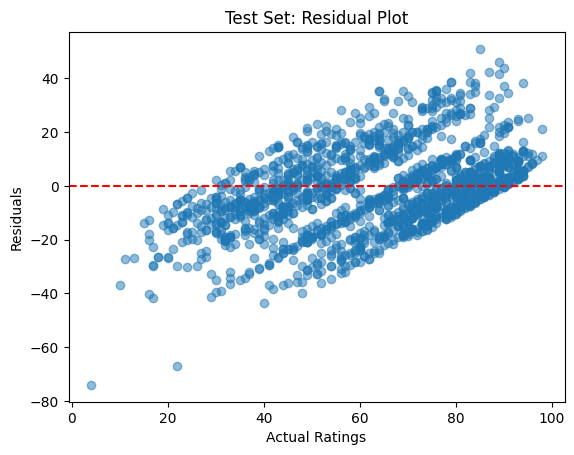

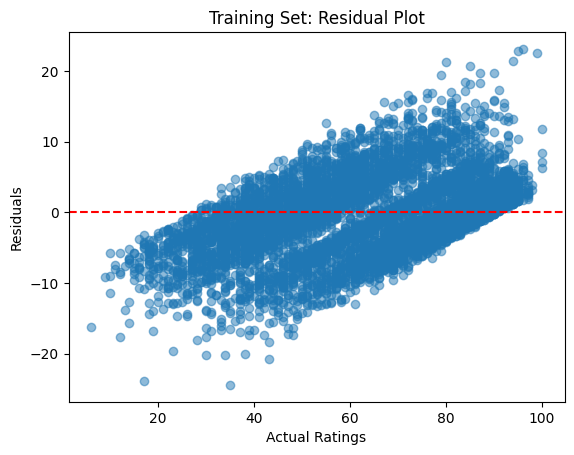

In [7]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Load the dataset with topic assignments
movie_data = pd.read_csv('movie_data_with_topics.csv')

# Define the features (X) and target variables (y)
X = movie_data[['movie_title', 'genre', 'relevant_topics', 'tomatometer_rating']]
y = movie_data['audience_rating']

# Split the dataset into training and test sets (e.g., 80% training and 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer for text data (topics)
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train['relevant_topics'].astype(str))
tfidf_matrix_test = tfidf_vectorizer.transform(X_test['relevant_topics'].astype(str))

# Combine TF-IDF features with other numerical features
X_train_combined = pd.concat([X_train[['tomatometer_rating']].reset_index(drop=True), pd.DataFrame(tfidf_matrix_train.toarray())], axis=1)
X_test_combined = pd.concat([X_test[['tomatometer_rating']].reset_index(drop=True), pd.DataFrame(tfidf_matrix_test.toarray())], axis=1)

# Convert feature names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Initialize and train the model (Random Forest Regressor is used here as an example)
model = RandomForestRegressor()
model.fit(X_train_combined, y_train)

# Predict on the test set
y_pred = model.predict(X_test_combined)
y_pred_train = model.predict(X_train_combined)

# Calculate Mean Squared Error (MSE) for test set
mse_test = mean_squared_error(y_test, y_pred)

# Calculate R-squared score for test set
r2_test = r2_score(y_test, y_pred)

# Print test metrics
print(f"Test MSE: {mse_test:.4f}")
print(f"Test R-squared: {r2_test:.4f}")

# Calculate Mean Squared Error (MSE) for overall validation set
mse_train = mean_squared_error(y_train, y_pred_train)

# Calculate R-squared score for overall validation set
r2_train = r2_score(y_train, y_pred_train)

# Print overall validation metrics
print(f"Overall Validation MSE: {mse_train:.4f}")
print(f"Overall Validation R-squared: {r2_train:.4f}")

# Residual plot for test set
plt.scatter(y_test, y_test - y_pred, alpha=0.5)
plt.title('Test Set: Residual Plot')
plt.xlabel('Actual Ratings')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Residual plot for training set
plt.scatter(y_train, y_train - y_pred_train, alpha=0.5)
plt.title('Training Set: Residual Plot')
plt.xlabel('Actual Ratings')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()





